# Proof of Concept: Using InvceptionV3 to classify persons based on footstep sounds

Mount my drive and extract the spectrograms to be used on Google Collab for training.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!unzip -q "/content/drive/My Drive/deepStep_data_spect.zip"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Define some of the paths that will be used during this script. Also, display some of the images, just to check if everything is fine.

In [0]:
import os

base_dir = 'data_spect'

train_dir = os.path.join(base_dir, 'train')
validate_dir = os.path.join(base_dir, 'validate')
test_dir = os.path.join(base_dir, 'test')

#read some file names
fnames = [os.path.join(path, fname) for path, dirs, files in os.walk(base_dir) for fname in files]

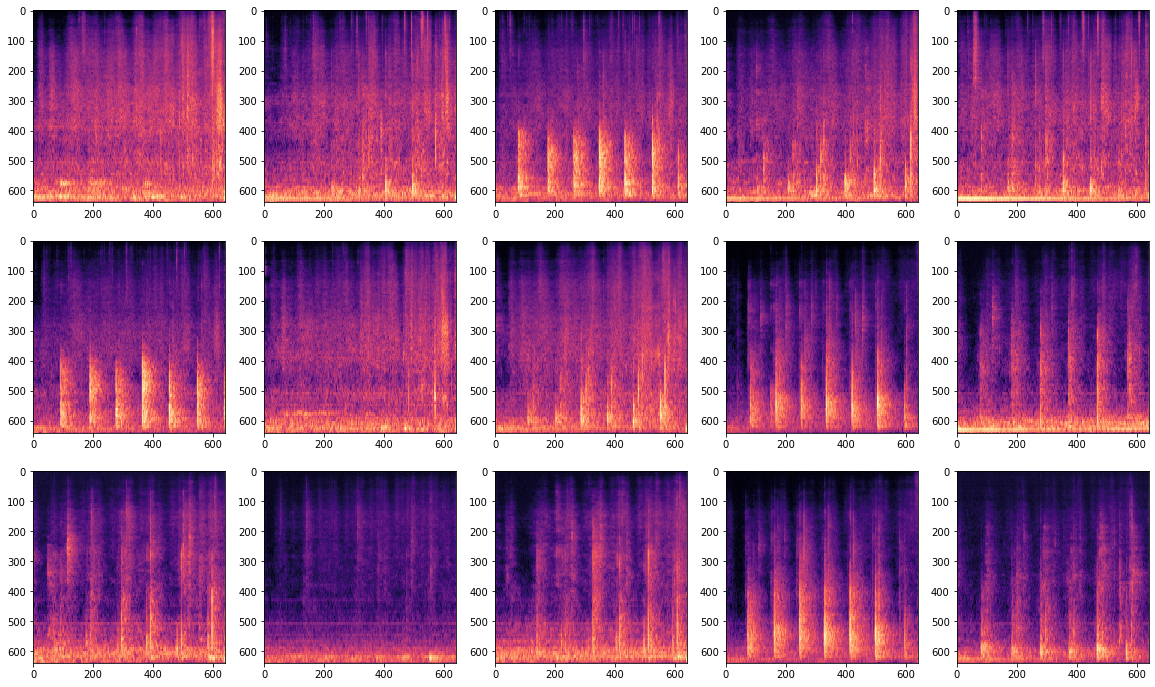

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows = 3
ncols = 5

fig = plt.figure()
fig.set_size_inches(ncols * 4, nrows * 4)

next_specgram = [fname for fname in fnames[:int(ncols*nrows)]]

for i, img_path in enumerate(next_specgram):
    sp = plt.subplot(nrows, ncols, i+1)
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

# 1 Generating bottleneck features

Bottleneck features are esentially the ouptus of the convolutional part of our pretrained CNN, which will be the inputs of our new dense classification network. Genereating the bottleneck features will enable us to train the new dense part, without having to run all of the images through the CNN part every time. This saves us quite a lot of computational capacity (at the cost of loosing the ability to use image augmentation).

In theory, we could generate augmented bottleneck features, but getting the correct labels for these would be quite tricky, and the transfer learning seems to still perform very well without this.

In [0]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input

from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Activation, Dropout
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

from matplotlib import pyplot as plt

import numpy as np

In [6]:
# Original InceptionV3 uses input shape of 299x299, but we have to specify because include_top = false
model_InV3 = InceptionV3(include_top = False, weights = 'imagenet', input_shape = (259, 259, 3))














87916544/87910968 [==============================] - 3s 0us/step


We don't need to generate the test bottleneck features, we'll only use our test dataset at the very end, where we've retrained all the network, not just the top layer.

In [0]:
# Use the built in InceptionV3 image preprocessing method
imDataGen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [8]:
#Create a generator for the training images
train_generator = imDataGen.flow_from_directory(directory = train_dir,
                                                target_size = (259, 259),
                                                shuffle = False, # We want to keep the order for now to be able to generate the labels easier in the future.
                                                batch_size = 1, # Batch size = 1 means we won't have to worry about all of our images fitting into integer number of batches
                                                class_mode = None) # We'll have to generate our own labels when using the bottleneck method
train_bottleNeck = model_InV3.predict_generator(generator = train_generator, verbose = 1)
np.save('train_bottleNeck.npy', train_bottleNeck)

Found 520 images belonging to 6 classes.
520/520 [==============================] - 25s 48ms/step


In [13]:
validate_generator = imDataGen.flow_from_directory(directory = validate_dir,
                                                   target_size = (259, 259),
                                                   shuffle = False,
                                                   batch_size = 1,
                                                   class_mode = None)
validate_bottleNeck = model_InV3.predict_generator(generator = validate_generator, verbose = 1)
np.save('validate_bottleNeck.npy', validate_bottleNeck)

Found 64 images belonging to 6 classes.
64/64 [==============================] - 3s 40ms/step


Define a very simple dense classification network for 6 classes

In [0]:
def build_top_model(input_shape, dense_layer_size):
    model = Sequential()

    model.add(Flatten(input_shape = input_shape))
    model.add(Dense(dense_layer_size[0], activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(dense_layer_size[1], activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax')) # Softmax for classification

    return model

This next cell will generate the correct labels, because we set ```shuffle = False```.

In [0]:
train_bottleNeck = np.load('train_bottleNeck.npy')
train_labels = to_categorical(train_generator.classes)

validate_bottleNeck = np.load('validate_bottleNeck.npy')
validate_labels = to_categorical(validate_generator.classes)

### 2 Training the top dense classification layer

Callbacks for training the dense layer:

In [0]:
early_stopping = EarlyStopping(patience = 200, verbose = 1)
checkpointer =  ModelCheckpoint(filepath = 'top_model.hdf5', save_best_only = True)
logger = CSVLogger('top_model_training.log')

Build the top dense layer. Loss function have to be categorical crossentropy, because we have 3 classes.

In [30]:
top_model = build_top_model(train_bottleNeck.shape[1:], [126, 32])
top_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
top_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 126)               9289854   
_________________________________________________________________
dropout_2 (Dropout)          (None, 126)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4064      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 198       
Total params: 9,294,116
Trainable params: 9,294,116
Non-trainable params: 0
____________________________________________

Train the dense classification layer:

In [33]:
history = top_model.fit(train_bottleNeck, train_labels,
                    epochs = 5000,
                    batch_size = 8,
                    verbose = 1,
                    shuffle = True,
                    validation_data = (validate_bottleNeck, validate_labels),
                    callbacks = [checkpointer, early_stopping, logger])

Train on 520 samples, validate on 64 samples
Epoch 1/5000
520/520 [==============================] - 1s 2ms/step - loss: 10.6053 - acc: 0.3115 - val_loss: 11.5849 - val_acc: 0.2812
Epoch 2/5000
520/520 [==============================] - 1s 2ms/step - loss: 10.9589 - acc: 0.3058 - val_loss: 11.5849 - val_acc: 0.2812
Epoch 3/5000
520/520 [==============================] - 1s 2ms/step - loss: 11.3122 - acc: 0.2731 - val_loss: 11.5849 - val_acc: 0.2812
Epoch 4/5000
520/520 [==============================] - 1s 2ms/step - loss: 10.7256 - acc: 0.2923 - val_loss: 11.5849 - val_acc: 0.2812
Epoch 5/5000
520/520 [==============================] - 1s 2ms/step - loss: 10.2673 - acc: 0.2750 - val_loss: 11.5849 - val_acc: 0.2812
Epoch 6/5000
520/520 [==============================] - 1s 2ms/step - loss: 10.0228 - acc: 0.2808 - val_loss: 11.5849 - val_acc: 0.2812
Epoch 7/5000
520/520 [==============================] - 1s 2ms/step - loss: 9.6239 - acc: 0.2635 - val_loss: 11.5849 - val_acc: 0.2812
Epoc

KeyboardInterrupt: ignored

At this point it's pretty clear, that training only a top dense layer based on the imagenet InceptionV3 is not working.

## Training the whole CNN

Let's try training the whole InceptionV3 with the created top classification layer.

In [35]:
train_generator = imDataGen.flow_from_directory(directory = train_dir,
                                                    target_size = (259, 259),
                                                    shuffle = True,
                                                    batch_size = 16, #Default batch size of 32 will not divied 1200, but we want to use all 1200 images to validate --> batch size of 16 will yield 75 batches
                                                    class_mode = 'categorical')

validate_generator = imDataGen.flow_from_directory(directory = validate_dir,
                                                       target_size = (259, 259),
                                                       shuffle = True,
                                                       batch_size = 4, #Default batch size of 32 will not divied 300, but we want to use all 300 images to validate --> batch size of 4 will yield 75 batches
                                                       class_mode = 'categorical')

# There's really no need to use augmentation on the test images, the network will not see these untill being finished with training.
test_generator = imDataGen.flow_from_directory(directory = test_dir,
                                               target_size = (259, 259),
                                               shuffle = False, # Otherwise we can't generate the correct labels for the ground trut for evaluation by hand (e.g. confusion matrix)
                                               batch_size = 1,
                                               class_mode = 'categorical')

Found 520 images belonging to 6 classes.
Found 64 images belonging to 6 classes.
Found 63 images belonging to 6 classes.


Building the full model. As we are retraing the whole model, I'll use the adam optimizer: I'm not concerned with 'ruining' the imagenet weights.

In [0]:
def build_full_model(bottom_model, top_model_weights_path, dense_layer_size):
    model = Sequential()

    model.add(bottom_model) # CNN part of InceptionV3
  
    top_model = build_top_model(bottom_model.output_shape[1:], dense_layer_size)
    # top_model.load_weights(top_model_weights_path) # Load the pretrained Dense part weights
    model.add(top_model)

    # Compile model with low learning rate SGD
    model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [53]:
 # Freeze the lower parts of InceptionV3, we only want to fine tune the more abstract feature extraction parts.
 # The boundary for trainable / non trainable layers is based on the practice of week 7.
for layer in model_InV3.layers:
    layer.trainable = True

full_model = build_full_model(model_InV3, 'top_model.hdf5', [126, 32])
full_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 6, 2048)        21802784  
_________________________________________________________________
sequential_8 (Sequential)    (None, 6)                 9294116   
Total params: 31,096,900
Trainable params: 31,062,468
Non-trainable params: 34,432
_________________________________________________________________


Callbacks for the full model training:

In [0]:
early_stopping = EarlyStopping(patience = 20, verbose = 1)
checkpointer =  ModelCheckpoint(filepath = 'full_model.hdf5', save_best_only = True)
logger = CSVLogger('InV3_model_training.log')

Train the model with adam:

## Note: The training you see below was continued from a previous run (the model weights were not reloded, so technically, this is not all the training cycles.

In [63]:
history = full_model.fit_generator(train_generator,
                    epochs = 200,
                    verbose = 1,
                    shuffle = True,
                    validation_data = validate_generator,
                    callbacks = [checkpointer, early_stopping, logger])

Epoch 1/200
33/33 [==============================] - 42s 1s/step - loss: 1.8170 - acc: 0.5889 - val_loss: 1.0546 - val_acc: 0.5312
Epoch 2/200
33/33 [==============================] - 20s 593ms/step - loss: 1.7234 - acc: 0.5625 - val_loss: 11.4127 - val_acc: 0.2656
Epoch 3/200
33/33 [==============================] - 20s 595ms/step - loss: 2.2874 - acc: 0.4963 - val_loss: 5.2545 - val_acc: 0.3906
Epoch 4/200
33/33 [==============================] - 20s 598ms/step - loss: 1.7915 - acc: 0.5510 - val_loss: 4.3521 - val_acc: 0.4219
Epoch 5/200
33/33 [==============================] - 20s 596ms/step - loss: 1.8669 - acc: 0.5815 - val_loss: 2.6605 - val_acc: 0.5469
Epoch 6/200
33/33 [==============================] - 20s 596ms/step - loss: 1.7685 - acc: 0.6137 - val_loss: 2.0365 - val_acc: 0.6250
Epoch 7/200
33/33 [==============================] - 20s 596ms/step - loss: 1.7876 - acc: 0.6515 - val_loss: 1.3939 - val_acc: 0.7188
Epoch 8/200
33/33 [==============================] - 20s 595ms/s

This training yielded a surprisingly good result, it was able to achieve an 89% accuracy, in the last epoch, even though the loss was not the best so far (according to early stopping, epoch 9 was the best which has a 78% accuracy. The training tends to have big oscillations in accuracy in loss though. I'm going to 'fine tune' the model, without reloading the best version (based on loss), with a much less agressive SGD optimzer, with low learning rate.

In [64]:
full_model.compile(optimizer = SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

history = full_model.fit_generator(train_generator,
                    epochs = 200,
                    verbose = 1,
                    shuffle = True,
                    validation_data = validate_generator,
                    callbacks = [checkpointer, early_stopping, logger])

Epoch 1/200
33/33 [==============================] - 48s 1s/step - loss: 0.9789 - acc: 0.7406 - val_loss: 0.6562 - val_acc: 0.8750
Epoch 2/200
33/33 [==============================] - 18s 532ms/step - loss: 0.9694 - acc: 0.7518 - val_loss: 0.6456 - val_acc: 0.8750
Epoch 3/200
33/33 [==============================] - 18s 535ms/step - loss: 0.9060 - acc: 0.7329 - val_loss: 0.6319 - val_acc: 0.8750
Epoch 4/200
33/33 [==============================] - 18s 533ms/step - loss: 0.9065 - acc: 0.7557 - val_loss: 0.6312 - val_acc: 0.8750
Epoch 5/200
33/33 [==============================] - 18s 537ms/step - loss: 0.8111 - acc: 0.7878 - val_loss: 0.6185 - val_acc: 0.8750
Epoch 6/200
33/33 [==============================] - 18s 537ms/step - loss: 0.7713 - acc: 0.7935 - val_loss: 0.6053 - val_acc: 0.8750
Epoch 7/200
33/33 [==============================] - 18s 534ms/step - loss: 0.8463 - acc: 0.7765 - val_loss: 0.5932 - val_acc: 0.8750
Epoch 8/200
33/33 [==============================] - 18s 535ms/st

This fine tuning managed to get the model up to 89% validation accuracy, with a loss of ~ 0.5, this seems to very good, considering this is just supposed to be a proof of concept.

Plot the accuracy during training:

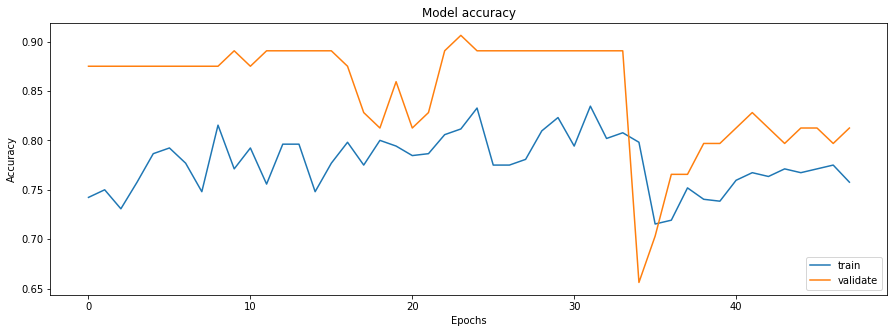

In [65]:
plt.figure(figsize = (15,5))

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validate'], loc='lower right')

plt.show()

## Evaluate the final model### 

In [0]:
full_model = load_model("full_model.hdf5") # Load back the best state of the model

In [67]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix
# Create predictions for the test images
test_preds = full_model.predict_generator(test_generator, verbose = 1)
test_preds = np.argmax(test_preds, 1)
# Ground truth labels for the test images (this works because shuffle = False)
test_true = test_generator.labels

print("Test accuracy: %g" %(accuracy_score(test_true, test_preds)))
print("Precision", precision_score(test_true, test_preds, average="macro"))
print("Recall", recall_score(test_true, test_preds, average="macro"))
print("f1_score", f1_score(test_true, test_preds, average="macro"))

63/63 [==============================] - 11s 182ms/step
Test accuracy: 0.84127
Precision 0.8463780980228348
Recall 0.8000000000000002
f1_score 0.8137351637351636


In [59]:
test_generator.class_indices

{'Cicca': 0, 'Kutya': 1, 'Nyuszi': 2, 'Poni': 3, 'hiveMind': 4, 'palinka': 5}

Plot a confusion matrix:

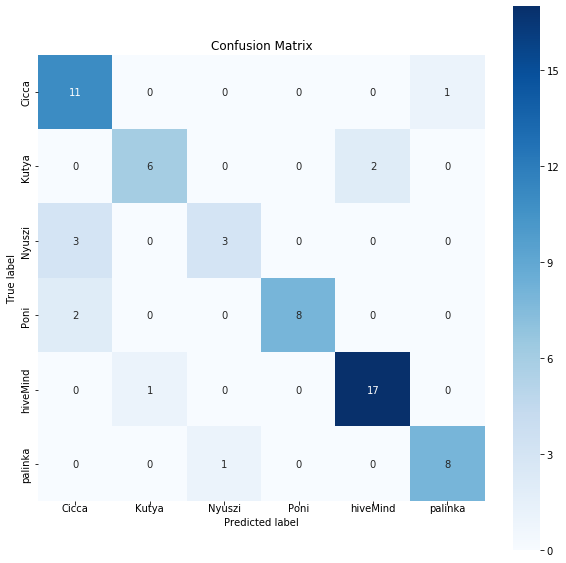

In [68]:
conf=confusion_matrix(test_true, test_preds)

import seaborn as sns

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.set_aspect(1)

res = sns.heatmap(conf, annot=True, vmin=0.0, fmt='d', cmap = plt.get_cmap('Blues'))

plt.yticks([0.5,1.5,2.5, 3.5, 4.5, 5.5], [ 'Cicca', 'Kutya', 'Nyuszi', 'Poni', 'hiveMind', 'palinka'],va='center')
plt.ylim([0, 6])
plt.ylabel('True label')
plt.xticks([0.5,1.5,2.5, 3.5, 4.5, 5.5], [ 'Cicca', 'Kutya', 'Nyuszi', 'Poni', 'hiveMind', 'palinka'],va='center')
plt.xlim([0, 6])
plt.xlabel('Predicted label')

res.invert_yaxis()

plt.title('Confusion Matrix')

plt.show()

Pretty good for the first try! Hopefully I'll be able to still improve on it.